# Stock Price Prediction

- To build the stock price prediction model, we will use the NSE TATA GLOBAL dataset. This is a dataset of Tata Beverages from Tata Global Beverages Limited, National Stock Exchange of India: Tata Global Dataset.
- Dataset Link(https://data.nasdaq.com/data/NSE/TATAGLOBAL-tata-global-beverages-limited)

# Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from keras.models import Sequential  # Fixed typo: Seqential -> Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

rcParams['figure.figsize'] = (20, 10)  # Parentheses added for tuple assignment


# Loading the Dataset

In [2]:
df = pd.read_csv(r"E:\Projects\Stock Price Prediction\Datasets\NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [3]:
df.shape

(1235, 8)

In [4]:
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [5]:
df.info

<bound method DataFrame.info of             Date    Open    High     Low    Last   Close  \
0     2018-10-08  208.00  222.25  206.85  216.00  215.15   
1     2018-10-05  217.00  218.60  205.90  210.25  209.20   
2     2018-10-04  223.50  227.80  216.15  217.25  218.20   
3     2018-10-03  230.00  237.50  225.75  226.45  227.60   
4     2018-10-01  234.55  234.60  221.05  230.30  230.90   
...          ...     ...     ...     ...     ...     ...   
1230  2013-10-14  160.85  161.45  157.70  159.30  159.45   
1231  2013-10-11  161.15  163.45  159.00  159.80  160.05   
1232  2013-10-10  156.00  160.80  155.85  160.30  160.15   
1233  2013-10-09  155.70  158.20  154.15  155.30  155.55   
1234  2013-10-08  157.00  157.80  155.20  155.80  155.80   

      Total Trade Quantity  Turnover (Lacs)  
0                4642146.0         10062.83  
1                3519515.0          7407.06  
2                1728786.0          3815.79  
3                1708590.0          3960.27  
4                

# Analyze the closing prices from Dataframe

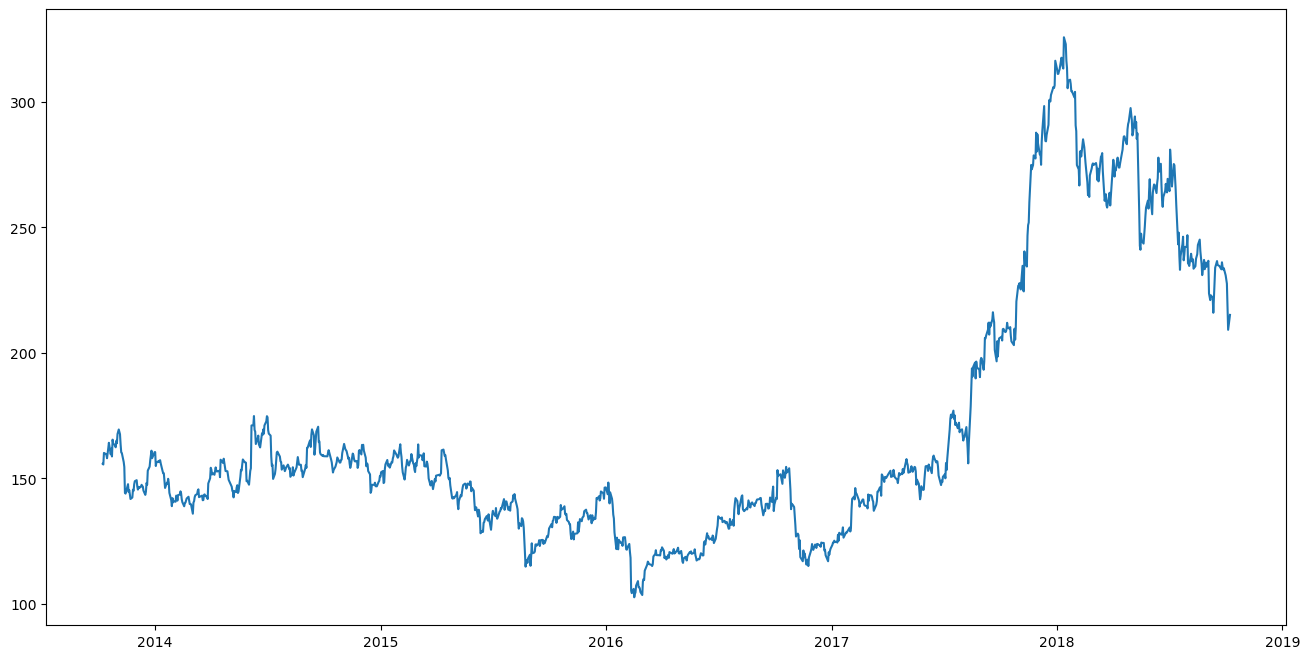

In [6]:
df['Date'] = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize= (16,8))
plt.plot(df["Close"], label = "Close Price History")

In [7]:
# Sort the dataset by index (ascending)
data = df.sort_index(ascending=True, axis=0)

# Create a new DataFrame with 'Date' and 'Close' columns
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

# Populate the new DataFrame using iloc for accessing by position
for i in range(0, len(data)):
    new_dataset.loc[i, "Date"] = data.iloc[i]["Date"]  # Use loc to assign values
    new_dataset.loc[i, "Close"] = data.iloc[i]["Close"]  # Use loc to assign values

# Normalize the new filtered Dataset 

In [8]:
# Ensure 'Date' is still in new_dataset before dropping it
if 'Date' in new_dataset.columns:
    new_dataset.index = new_dataset['Date']  
    new_dataset.drop('Date', axis=1, inplace=True)  # Droping the 'Date' column after setting as index

# Convert the new_dataset to a NumPy array (now contains only numeric values)
final_dataset = new_dataset.values

C:\Users\ashu1\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


####  Scaler and Scale the data

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

#### Split the data into training and validation sets

In [10]:
train_data = scaled_data[0:987, :]
valid_data = scaled_data[987:, :]


#### Preparing the training data

In [11]:
x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])  # Take 60 timesteps before the current value
    y_train_data.append(scaled_data[i, 0])  # Take the current value as the target


In [12]:
# Convert to NumPy arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape the training data to be compatible with LSTM input
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

# Build and train the LSTM model

In [13]:
from keras.layers import  Input

# Model architecture
lstm_model = Sequential()

# Use Input layer for defining input shape explicitly
lstm_model.add(Input(shape=(x_train_data.shape[1], 1)))  # Input layer
lstm_model.add(LSTM(units=50, return_sequences=True))  # First LSTM layer
lstm_model.add(LSTM(units=50))  # Second LSTM layer without return_sequences
lstm_model.add(Dense(1))  # Output layer

# Prepare the inputs for the model
inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model on the training data
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)


927/927 - 18s - 20ms/step - loss: 9.5474e-04


### Take a Sample of dataset to make stock price predictions using the LSTM model 

In [14]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


## Save the LSTM model

In [15]:
lstm_model.save("saved_model.h5")

## Visualize the predicted stock costs with actual stock costs

C:\Users\ashu1\AppData\Local\Temp\ipykernel_3104\107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


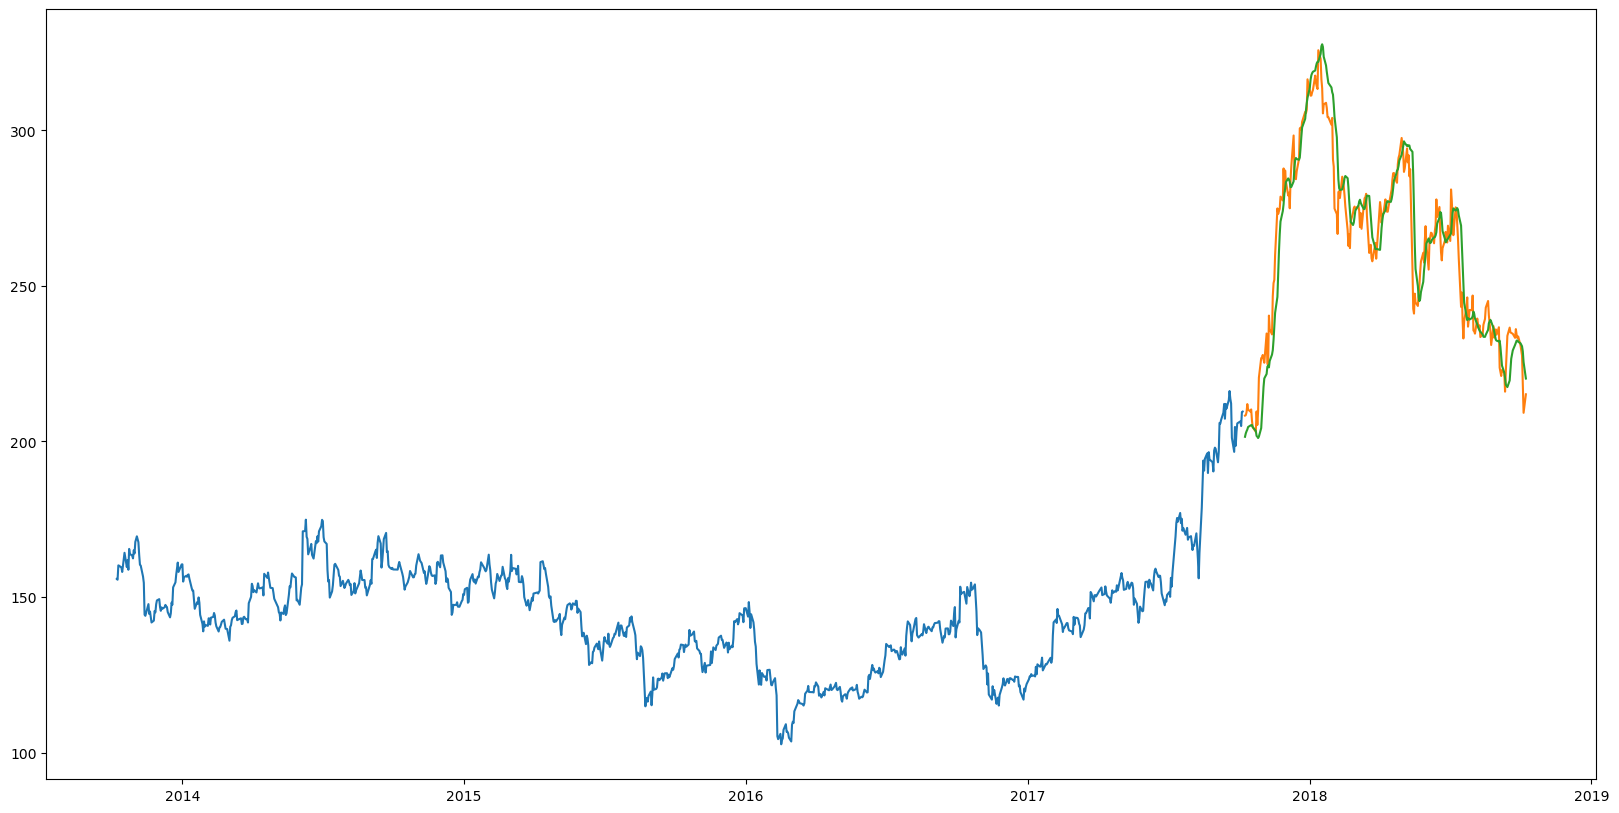

In [16]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

We can observe that LSTM has predicted stocks almost similar to actual stocks.

# Build The dashboard using Plotly Dash

#### To develop the dashboard for stock analysis we will use another stock dataset with multiple stocks like Apple, Microsoft, Facebook: Stocks Dataset

In [17]:
!pip install dash
!pip install dash-html-components
!pip install dash-core-components

In [18]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [19]:
app = dash.Dash(__name__)
server = app.server

scaler = MinMaxScaler(feature_range=(0, 1))

df_nse = pd.read_csv(r"E:\Projects\Stock Price Prediction\Datasets\NSE-Tata-Global-Beverages-Limited.csv")

df_nse["Date"] = pd.to_datetime(df_nse.Date, format="%Y-%m-%d")
df_nse.set_index('Date', inplace=True)

data = df_nse.sort_index(ascending=True)
new_data = pd.DataFrame(data['Close'])

In [20]:
dataset = new_data.values

train = dataset[:987]
valid = dataset[987:]

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [22]:
x_train, y_train = [], []

for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [23]:
model = load_model("saved_model.h5")

inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [24]:

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [25]:
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price

C:\Users\ashu1\AppData\Local\Temp\ipykernel_3104\1049121608.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:

df = pd.read_csv(r"E:\Projects\Stock Price Prediction\Datasets\stock_data.csv")

app.layout = html.Div([
    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),
    
    dcc.Tabs(id="tabs", children=[
        dcc.Tab(label='NSE-TATAGLOBAL Stock Data', children=[
            html.Div([
                html.H2("Actual closing price", style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data": [
                            go.Scatter(
                                x=train.index,
                                y=valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout": go.Layout(
                            title='Scatter plot',
                            xaxis={'title': 'Date'},
                            yaxis={'title': 'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted closing price", style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data": [
                            go.Scatter(
                                x=valid.index,
                                y=valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout": go.Layout(
                            title='Scatter plot',
                            xaxis={'title': 'Date'},
                            yaxis={'title': 'Closing Rate'}
                        )
                    }
                )                
            ])
        ]),
        dcc.Tab(label='Facebook Stock Data', children=[
            html.Div([
                html.H1("Facebook Stocks High vs Lows", 
                        style={'textAlign': 'center'}),
              
                dcc.Dropdown(
                    id='my-dropdown',
                    options=[
                        {'label': 'Tesla', 'value': 'TSLA'},
                        {'label': 'Apple', 'value': 'AAPL'}, 
                        {'label': 'Facebook', 'value': 'FB'}, 
                        {'label': 'Microsoft', 'value': 'MSFT'}
                    ], 
                    multi=True,
                    value=['FB'],
                    style={"display": "block", "margin-left": "auto", 
                           "margin-right": "auto", "width": "60%"}
                ),
                dcc.Graph(id='highlow'),
                html.H1("Facebook Market Volume", style={'textAlign': 'center'}),
         
                dcc.Dropdown(
                    id='my-dropdown2',
                    options=[
                        {'label': 'Tesla', 'value': 'TSLA'},
                        {'label': 'Apple', 'value': 'AAPL'}, 
                        {'label': 'Facebook', 'value': 'FB'},
                        {'label': 'Microsoft', 'value': 'MSFT'}
                    ], 
                    multi=True,
                    value=['FB'],
                    style={"display": "block", "margin-left": "auto", 
                           "margin-right": "auto", "width": "60%"}
                ),
                dcc.Graph(id='volume')
            ], className="container"),
        ])
    ])
])

@app.callback(
    Output('highlow', 'figure'),
    [Input('my-dropdown', 'value')]
)
def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla", "AAPL": "Apple", "FB": "Facebook", "MSFT": "Microsoft"}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
            go.Scatter(
                x=df[df["Stock"] == stock]["Date"],
                y=df[df["Stock"] == stock]["High"],
                mode='lines', 
                opacity=0.7, 
                name=f'High {dropdown[stock]}',
                textposition='bottom center'
            )
        )
        trace2.append(
            go.Scatter(
                x=df[df["Stock"] == stock]["Date"],
                y=df[df["Stock"] == stock]["Low"],
                mode='lines', 
                opacity=0.6,
                name=f'Low {dropdown[stock]}',
                textposition='bottom center'
            )
        )
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {
        'data': data,
        'layout': go.Layout(
            colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title": "Date",
                   'rangeselector': {'buttons': list([
                       {'count': 1, 'label': '1M', 'step': 'month', 'stepmode': 'backward'},
                       {'count': 6, 'label': '6M', 'step': 'month', 'stepmode': 'backward'},
                       {'step': 'all'}
                   ])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
            yaxis={"title": "Price (USD)"}
        )
    }
    return figure

@app.callback(
    Output('volume', 'figure'),
    [Input('my-dropdown2', 'value')]
)
def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla", "AAPL": "Apple", "FB": "Facebook", "MSFT": "Microsoft"}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
            go.Scatter(
                x=df[df["Stock"] == stock]["Date"],
                y=df[df["Stock"] == stock]["Volume"],
                mode='lines', 
                opacity=0.7,
                name=f'Volume {dropdown[stock]}', 
                textposition='bottom center'
            )
        )
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {
        'data': data, 
        'layout': go.Layout(
            colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title": "Date",
                   'rangeselector': {'buttons': list([
                       {'count': 1, 'label': '1M', 'step': 'month', 'stepmode': 'backward'},
                       {'count': 6, 'label': '6M', 'step': 'month', 'stepmode': 'backward'},
                       {'step': 'all'}
                   ])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
            yaxis={"title": "Transactions Volume"}
        )
    }
    return figure

if __name__ == '__main__':
    app.run_server(debug=True)

In this Project we have developed a stock cost prediction model and build an interactive dashboard for stock analysis. We implemented Stock market prediction using the LSTM model.
OTOH, Plotly dash python framework for building dashboards.